In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import json
import baseline
import numpy as np
from baseline import *
from decoder import *
from alphabet import *
from train import *
import torch
from matplotlib import pyplot as plt
import collections

torch.__version__

'1.4.0'

In [3]:
def filter_ascii(strings):
    'Returns only the strings that can be encoded in ASCII.'
    l = []
    for s in strings:
        try:
            s.encode('ascii')
            if 10 <= len(s) <= 80:
                l.append(s)
        except UnicodeEncodeError:
            pass
        
    return list(set(l))

def language_2_dataset(language='Python'):
    with open('dataset/large.json') as f:
        multilang_dataset = json.load(f)
        dataset = multilang_dataset[language]

        dataset['train'] = filter_ascii(dataset['train'])
        dataset['dev'] = filter_ascii(dataset['dev'])
        dataset['test'] = filter_ascii(dataset['test'])
        print('{} training examples, {} validation examples, {} test exampless'.format(
            len(dataset['train']), 
            len(dataset['dev']),
            len(dataset['test'])))
        return dataset
    
dataset = language_2_dataset(language='Python')

602762 training examples, 80964 validation examples, 80789 test exampless


In [4]:
def dump_parameters(model_losses, filename):
    torch.save(model_losses['decoder_state_dict'], filename + "decoder.model")
    torch.save(model_losses['alphabet_state_dict'], filename + "alphabet.model")
    del model_losses['decoder_state_dict']
    del model_losses['alphabet_state_dict']        
    js = json.dumps(model_losses)
    with open(filename + '.json', "w") as f:
        f.write(js)

In [5]:
def run_model(model):
    device = torch.device(0) if torch.cuda.is_available() else torch.device('cpu')
    print(device)
    model, alpha, dataset, lang_name = model
    
    alphabet = AsciiEmbeddedEncoding(device)
    encoder = model
    decoder = AutoCompleteDecoderModel(alphabet, hidden_size=512, copy=None)
    parameters  = {
        'learning_rate': alpha,
        'verbose': True,
        'batch_size': 128,
        'init_scale': 0.1,
        'timeout': 6*60*60
    }
    param_dict = train(encoder, decoder, dataset, parameters, alphabet, device)
    filename = "{}_{}_{}".format(model.name(), alpha, lang_name)
    dump_parameters(param_dict, filename)
    return param_dict

In [6]:
python_dat = language_2_dataset('Python')
java_dat = language_2_dataset('Java')
haskell_dat = language_2_dataset('Haskell')

602762 training examples, 80964 validation examples, 80789 test exampless
565796 training examples, 77886 validation examples, 77884 test exampless
616686 training examples, 82731 validation examples, 82543 test exampless


In [7]:
"""
models = [
    (UniformEncoder(removal_probability=.6),.0005, python_dat, 'python'),
    (UniformEncoder(removal_probability=.7),.0005, python_dat, 'python'), 
    (UniformEncoder(removal_probability=.8),.0005, python_dat, 'python'), 
    (RulesBasedEncoder(), .0001, python_dat, 'python'),
    (UniformEncoder(removal_probability=.9) , .0001, python_dat, 'python'), 
    (FrequencyEncoder(dataset=python_dat['train'], compression_rate=.8, n_gram=5), .0005, python_dat, 'python'), 
    (FrequencyEncoder(dataset=python_dat['train'], compression_rate=.9, n_gram=5), .0005, python_dat, 'python'), 
    (NonDeterministicFrequencyEncoder(dataset=python_dat['train'], compression_rate=.8, n_gram=5), .0005, python_dat, 'python'),
    (FuzzyFrequencyEncoder(dataset=python_dat['train'], compression_rate=.8, n_gram=5), .0005, python_dat, 'python'),
    (UniformFrequencyHybridEncoder(dataset=python_dat['train'], compression_rate=.8, n_gram=5, removal_probability=0.8), .0005, python_dat, 'python'),
    (FrequencyEncoderConstantDrop(dataset=python_dat['train'], num_chars=5, n_gram=5), .0005, python_dat, 'python'),
    (FrequencyEncoderConstantDrop(java_dat['train'], num_chars=5, n_gram=5), .0005, java_dat, 'java'),
    (FrequencyEncoderConstantDrop(haskell_dat['train'], num_chars=5, n_gram=5), .0005, haskell_dat, 'haskell'),
    (UniformEncoderConstantDrop(num_chars=5), .0005, python_dat, 'python'),
    (UniformEncoderConstantDrop(num_chars=5), .0005, java_dat, 'java'),
    (UniformEncoderConstantDrop(num_chars=5), .0005, haskell_dat, 'haskell')
    ]
"""
models = [
    #(NonDeterministicFrequencyEncoder(dataset=python_dat['train'], compression_rate=.7, n_gram=5), .0005, python_dat, 'python'),
    #(FuzzyFrequencyEncoder(dataset=python_dat['train'], compression_rate=.8, n_gram=5), .0005, python_dat, 'python')
    (UniformEncoder(removal_probability=.6),.0005, python_dat, 'python'),
    (UniformEncoder(removal_probability=.7),.0005, python_dat, 'python'), 
    (UniformEncoder(removal_probability=.8),.0005, python_dat, 'python') 
    
]
V1 = models
# V2 = models[4:7]
# V3 = models[7:]

In [133]:
for model in V1:
    print('Training', model[0].name())
    results = run_model(model)

Training FuzzyFrequencyEncoder(5-gram, target_size:0.8)
cuda:0
Epoch 0 iteration 0: loss = 4.878, tp = 236.68 lines/s, ETA 00h42m26s
Epoch 0 iteration 100: loss = 3.441, tp = 298.87 lines/s, ETA 00h32m53s
Epoch 0 iteration 200: loss = 2.829, tp = 298.80 lines/s, ETA 00h32m11s
Epoch 0 iteration 300: loss = 2.012, tp = 298.98 lines/s, ETA 00h31m27s
Epoch 0 iteration 400: loss = 1.433, tp = 299.19 lines/s, ETA 00h30m43s
Epoch 0 iteration 500: loss = 1.074, tp = 299.29 lines/s, ETA 00h30m00s
Epoch 0 iteration 600: loss = 0.954, tp = 298.86 lines/s, ETA 00h29m19s
Epoch 0 iteration 700: loss = 0.851, tp = 298.89 lines/s, ETA 00h28m36s
Epoch 0 iteration 800: loss = 0.785, tp = 299.11 lines/s, ETA 00h27m52s
Epoch 0 iteration 900: loss = 0.756, tp = 298.88 lines/s, ETA 00h27m11s
Epoch 0 iteration 1000: loss = 0.756, tp = 298.73 lines/s, ETA 00h26m29s
Epoch 0 iteration 1100: loss = 0.725, tp = 298.66 lines/s, ETA 00h25m46s
Epoch 0 iteration 1200: loss = 0.691, tp = 298.73 lines/s, ETA 00h25m03s


Epoch 2 iteration 1780: loss = 0.324, tp = 298.73 lines/s, ETA -1h13m39s
Epoch 2 iteration 1880: loss = 0.324, tp = 298.74 lines/s, ETA -1h12m56s
Epoch 2 iteration 1980: loss = 0.329, tp = 298.74 lines/s, ETA -1h12m14s
Epoch 2 iteration 2080: loss = 0.288, tp = 298.73 lines/s, ETA -1h11m31s
Epoch 2 iteration 2180: loss = 0.290, tp = 298.73 lines/s, ETA -1h10m48s
Epoch 2 iteration 2280: loss = 0.288, tp = 298.73 lines/s, ETA -1h10m05s
Epoch 2 iteration 2380: loss = 0.290, tp = 298.72 lines/s, ETA -1h09m22s
Epoch 2 iteration 2480: loss = 0.335, tp = 298.71 lines/s, ETA -1h08m39s
Epoch 2 iteration 2580: loss = 0.340, tp = 298.70 lines/s, ETA -1h07m56s
Epoch 2 iteration 2680: loss = 0.328, tp = 298.70 lines/s, ETA -1h07m13s
Epoch 2 iteration 2780: loss = 0.296, tp = 298.70 lines/s, ETA -1h06m30s
Epoch 2 iteration 2880: loss = 0.263, tp = 298.68 lines/s, ETA -1h05m47s
Epoch 2 iteration 2980: loss = 0.253, tp = 298.68 lines/s, ETA -1h05m04s
Epoch 2 iteration 3080: loss = 0.340, tp = 298.68 l

Epoch 4 iteration 3660: loss = 0.246, tp = 298.29 lines/s, ETA -3h52m46s
Epoch 4 iteration 3760: loss = 0.278, tp = 298.28 lines/s, ETA -3h52m03s
Epoch 4 iteration 3860: loss = 0.231, tp = 298.29 lines/s, ETA -3h51m20s
Epoch 4 iteration 3960: loss = 0.260, tp = 298.28 lines/s, ETA -3h50m37s
Epoch 4 iteration 4060: loss = 0.235, tp = 298.28 lines/s, ETA -3h49m54s
Epoch 4 iteration 4160: loss = 0.259, tp = 298.29 lines/s, ETA -3h49m11s
Epoch 4 iteration 4260: loss = 0.255, tp = 298.29 lines/s, ETA -3h48m29s
Epoch 4 iteration 4360: loss = 0.260, tp = 298.29 lines/s, ETA -3h47m46s
Epoch 4 iteration 4460: loss = 0.255, tp = 298.28 lines/s, ETA -3h47m03s
Epoch 4 iteration 4560: loss = 0.278, tp = 298.29 lines/s, ETA -3h46m20s
Epoch 4 iteration 4660: loss = 0.257, tp = 298.29 lines/s, ETA -3h45m37s
Epoch 5 iteration 50: loss = 0.259, tp = 298.28 lines/s, ETA -3h44m54s
Epoch 5 iteration 150: loss = 0.249, tp = 298.28 lines/s, ETA -3h44m11s
Epoch 5 iteration 250: loss = 0.233, tp = 298.28 lines

Epoch 7 iteration 830: loss = 0.224, tp = 298.10 lines/s, ETA -4h31m49s
Epoch 7 iteration 930: loss = 0.228, tp = 298.10 lines/s, ETA -4h31m06s
Epoch 7 iteration 1030: loss = 0.248, tp = 298.10 lines/s, ETA -4h30m24s
Epoch 7 iteration 1130: loss = 0.248, tp = 298.11 lines/s, ETA -4h29m41s
Epoch 7 iteration 1230: loss = 0.249, tp = 298.11 lines/s, ETA -4h28m58s
Epoch 7 iteration 1330: loss = 0.247, tp = 298.11 lines/s, ETA -4h28m15s
Epoch 7 iteration 1430: loss = 0.235, tp = 298.11 lines/s, ETA -4h27m32s
Epoch 7 iteration 1530: loss = 0.261, tp = 298.12 lines/s, ETA -4h26m49s
Epoch 7 iteration 1630: loss = 0.219, tp = 298.11 lines/s, ETA -4h26m06s
Epoch 7 iteration 1730: loss = 0.264, tp = 298.12 lines/s, ETA -4h25m24s
Epoch 7 iteration 1830: loss = 0.261, tp = 298.12 lines/s, ETA -4h24m41s
Epoch 7 iteration 1930: loss = 0.211, tp = 298.12 lines/s, ETA -4h23m58s
Epoch 7 iteration 2030: loss = 0.224, tp = 298.12 lines/s, ETA -4h23m15s
Epoch 7 iteration 2130: loss = 0.205, tp = 298.12 lin

Epoch 9 iteration 2710: loss = 0.203, tp = 298.13 lines/s, ETA -5h10m59s
Epoch 9 iteration 2810: loss = 0.231, tp = 298.12 lines/s, ETA -5h10m16s
Epoch 9 iteration 2910: loss = 0.255, tp = 298.13 lines/s, ETA -5h09m33s
Epoch 9 iteration 3010: loss = 0.224, tp = 298.12 lines/s, ETA -5h08m49s
Epoch 9 iteration 3110: loss = 0.209, tp = 298.11 lines/s, ETA -5h08m06s
Epoch 9 iteration 3210: loss = 0.282, tp = 298.11 lines/s, ETA -5h07m23s
Epoch 9 iteration 3310: loss = 0.228, tp = 298.11 lines/s, ETA -5h06m40s
Epoch 9 iteration 3410: loss = 0.252, tp = 298.11 lines/s, ETA -5h05m57s
Epoch 9 iteration 3510: loss = 0.188, tp = 298.12 lines/s, ETA -5h05m15s
Epoch 9 iteration 3610: loss = 0.268, tp = 298.11 lines/s, ETA -5h04m32s
Epoch 9 iteration 3710: loss = 0.232, tp = 298.12 lines/s, ETA -5h03m49s
Epoch 9 iteration 3810: loss = 0.194, tp = 298.12 lines/s, ETA -5h03m06s
Epoch 9 iteration 3910: loss = 0.232, tp = 298.12 lines/s, ETA -5h02m23s
Epoch 9 iteration 4010: loss = 0.257, tp = 298.11 l

In [73]:

def tune_hyperparams(dataset, curr_model_loss=collections.defaultdict(list)):
    device = torch.device(0) if torch.cuda.is_available() else torch.device('cpu')
    print("device is ", device)
    learning_rates = [.0001,.0005 ,.001,.005 ,.01]
    compression_rates = [.95, .9, .85, .8]
    num_to_drop = [9,3,5]
    name_dict = {
        UniformEncoderConstantDrop : "UniformEncoderConstantDrop",
        FrequencyEncoderConstantDrop : 'FrequencyEncoderConstantDrop',
        UniformEncoder : 'UniformEncoder',
        FrequencyEncoder : 'FrequencyEncoder',
        RulesBasedEncoder : 'RulesBasedEncoder'
    }
    rules_based = ['whitespace', 'no_whitespace'] # just pass it as an extra param to init
    models = [UniformEncoderConstantDrop, FrequencyEncoderConstantDrop, UniformEncoder, FrequencyEncoder, RulesBasedEncoder]
    # can use across all models
    alphabet = AsciiOneHotEncoding(device)

    for model in models:
        for alpha in learning_rates:
            if model is UniformEncoder or model is FrequencyEncoder:
                for compression in compression_rates:
                    print("trying model %s learning rate %s compression %s" % (model, alpha, compression))
                    encoder = model(compression) if model is UniformEncoder else model(dataset['train'], compression, n_gram=5)
                    
                    if encoder.name() in curr_model_loss:
                        continue
                    
                    decoder = AutoCompleteDecoderModel(alphabet, hidden_size=512, copy=None)
                    parameters  = {
                        'learning_rate': alpha,
                        'verbose': True,
                        'batch_size': 64,
                        'init_scale': 0.01,
                        'epochs': 10
                    }
                    train_loss_history = train(encoder, decoder, dataset, parameters, device)
                    curr_model_loss[encoder.name()].append({
                        "lr": alpha,
                        "loss_history": train_loss_history
                    })
                    dump_parameters(curr_model_loss)
            elif model is UniformEncoderConstantDrop or model is FrequencyEncoderConstantDrop:
                for drop in num_to_drop:
                    print("trying model %s learning rate %s drop %s" % (model, alpha, drop))
                    encoder = model(drop) if model is UniformEncoderConstantDrop else model(dataset['train'], drop, n_gram=5)
                    
                    if encoder.name() in curr_model_loss:
                        continue

                    decoder = AutoCompleteDecoderModel(alphabet, hidden_size=512, copy=None)
                    parameters  = {
                        'learning_rate': alpha,
                        'verbose': True,
                        'batch_size': 64,
                        'init_scale': 0.01,
                        'epochs': 10
                    }                    
                    train_loss_history = train(encoder, decoder, dataset, parameters, device)
                    curr_model_loss[encoder.name()].append({
                        "lr": alpha,
                        "loss_history": train_loss_history
                    })
                    dump_parameters(curr_model_loss)
            else:
                for rule in rules_based:
                    print("trying model %s learning rate %s rule %s" % (model, alpha, rule))
                    encoder = model(rule == 'whitespace')
                    
                    if encoder.name() in curr_model_loss:
                        continue
                    
                    decoder = AutoCompleteDecoderModel(alphabet, hidden_size=512, copy=None)
                    parameters  = {
                        'learning_rate': alpha,
                        'verbose': True,
                        'batch_size': 64,
                        'init_scale': 0.01,
                        'epochs': 10
                    }                    
                    train_loss_history = train(encoder, decoder, dataset, parameters, device)
                    curr_model_loss[encoder.name()].append({
                        "lr": alpha,
                        "loss_history": train_loss_history
                    })
                    dump_parameters(curr_model_loss)

        models_loss[str(model)] = curr_model_loss    
    
    return curr_model_loss

In [ ]:
test_losses = tune_hyperparams(dataset)

device is  cuda:0
trying model <class 'baseline.UniformEncoderConstantDrop'> learning rate 0.0001 drop 9
Epoch 0 iteration 0: loss = 2.437, tp = 158.23 lines/s, ETA 00h07m28s
Epoch 0 iteration 100: loss = 1.628, tp = 212.43 lines/s, ETA 00h05m03s
Epoch 1 iteration 89: loss = 1.543, tp = 212.70 lines/s, ETA 00h04m33s
Epoch 2 iteration 78: loss = 1.648, tp = 213.04 lines/s, ETA 00h04m03s
Epoch 3 iteration 67: loss = 1.549, tp = 213.17 lines/s, ETA 00h03m32s
Epoch 4 iteration 56: loss = 1.762, tp = 213.20 lines/s, ETA 00h03m02s
Epoch 5 iteration 45: loss = 1.668, tp = 213.22 lines/s, ETA 00h02m32s
Epoch 6 iteration 34: loss = 1.547, tp = 213.11 lines/s, ETA 00h02m02s
Epoch 7 iteration 23: loss = 1.640, tp = 213.10 lines/s, ETA 00h01m32s
Epoch 8 iteration 12: loss = 1.627, tp = 213.15 lines/s, ETA 00h01m02s
Epoch 9 iteration 1: loss = 1.629, tp = 213.12 lines/s, ETA 00h00m32s
Epoch 9 iteration 101: loss = 1.518, tp = 213.32 lines/s, ETA 00h00m02s
trying model <class 'baseline.UniformEncode

Epoch 0 iteration 0: loss = 1.549, tp = 135.50 lines/s, ETA 00h00m51s
Epoch 0 iteration 100: loss = 1.311, tp = 178.08 lines/s, ETA 00h00m03s


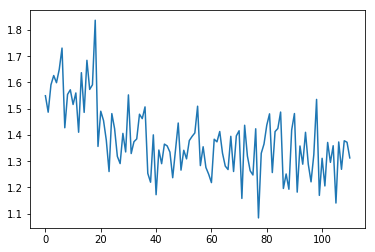

In [4]:
parameters = {
    'learning_rate': 1e-4,
    'verbose': True,
    'batch_size': 64,
    'init_scale': 0.01,
    'epochs': 1,
}

train_loss_history = train(encoder, decoder_copy, dataset, parameters, device)
plt.plot(train_loss_history)

# Looking at losses from hyperparameter search

In [2]:
with open("test_losses.json") as json_file:
    test_losses = json.load(json_file)

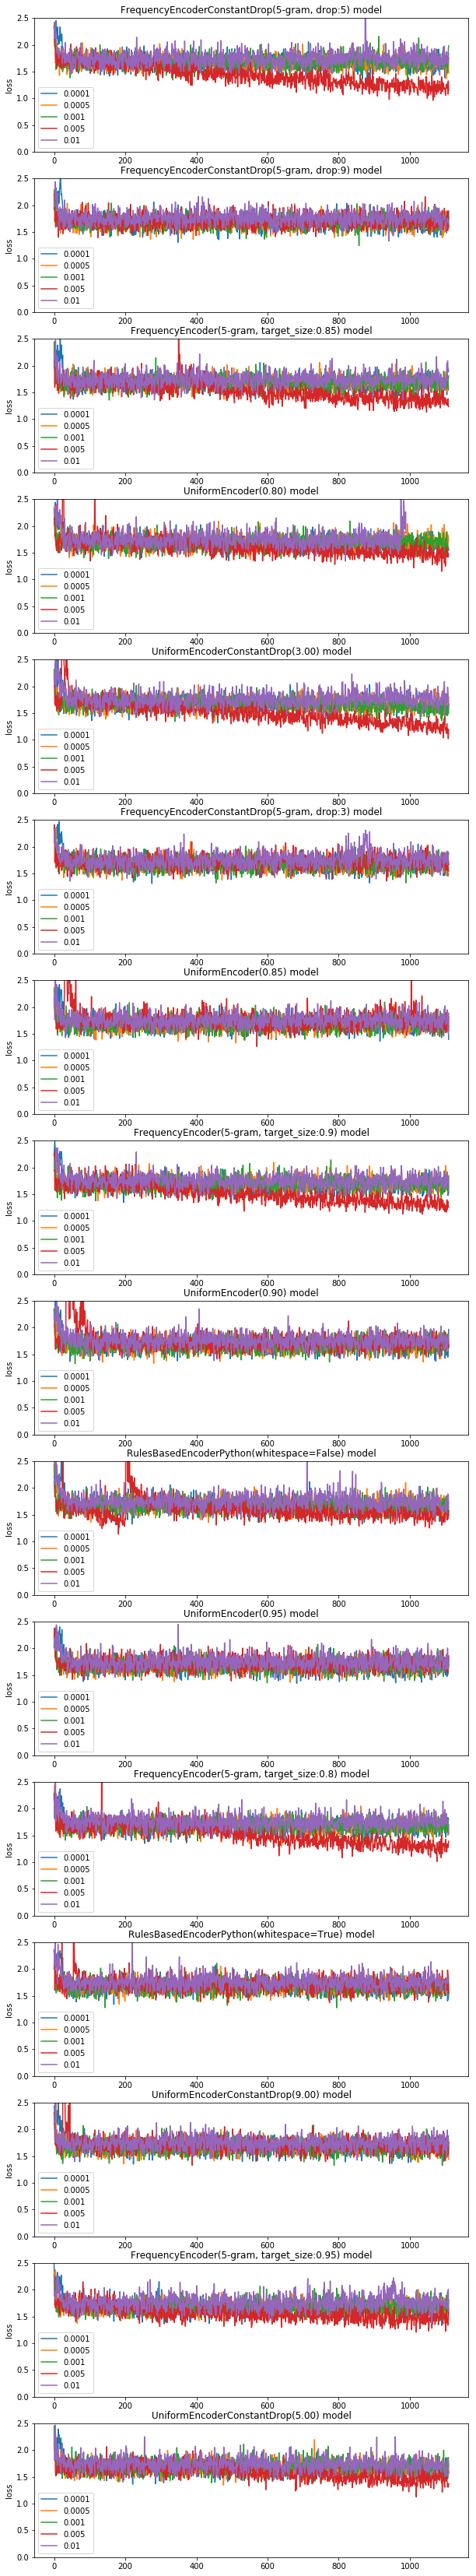

In [9]:
fig, axs = plt.subplots(len(test_losses), sharey=True, figsize=(10,60))
plt.set_cmap('Accent')
for ax, name, model in zip(axs, test_losses.keys(), test_losses.values()):
    i = 0
    for rates in model:
        learn_rate = rates['lr']
        loss = rates['loss_history']
        timesteps = np.arange(len(loss))
        ax.plot(timesteps, loss, label=learn_rate)
        min_val = min(loss)
#         ax.annotate(("LR:"+ str(learn_rate) + " min:" + str( round(min_val, 3))), (loss[0], timesteps[i]) )
        i +=  100
#     ax.set_xlabel('time step')
    ax.set_ylim([0.0, 2.5])
    ax.set_ylabel('loss')
    ax.title.set_text(str(name) + ' model')
    ax.legend()

In [10]:
for name, model in zip(test_losses.keys(), test_losses.values()):
    for rates in model:
        learn_rate = rates['lr']
        loss = rates['loss_history']
        print("model:" + str(name) +  "LR:"+ str(learn_rate) + " min:" + str( round(min(loss), 3)))

model:FrequencyEncoderConstantDrop(5-gram, drop:5)LR:0.0001 min:1.363
model:FrequencyEncoderConstantDrop(5-gram, drop:5)LR:0.0005 min:1.357
model:FrequencyEncoderConstantDrop(5-gram, drop:5)LR:0.001 min:1.328
model:FrequencyEncoderConstantDrop(5-gram, drop:5)LR:0.005 min:0.96
model:FrequencyEncoderConstantDrop(5-gram, drop:5)LR:0.01 min:1.406
model:FrequencyEncoderConstantDrop(5-gram, drop:9)LR:0.0001 min:1.305
model:FrequencyEncoderConstantDrop(5-gram, drop:9)LR:0.0005 min:1.362
model:FrequencyEncoderConstantDrop(5-gram, drop:9)LR:0.001 min:1.243
model:FrequencyEncoderConstantDrop(5-gram, drop:9)LR:0.005 min:1.392
model:FrequencyEncoderConstantDrop(5-gram, drop:9)LR:0.01 min:1.325
model:FrequencyEncoder(5-gram, target_size:0.85)LR:0.0001 min:1.333
model:FrequencyEncoder(5-gram, target_size:0.85)LR:0.0005 min:1.367
model:FrequencyEncoder(5-gram, target_size:0.85)LR:0.001 min:1.353
model:FrequencyEncoder(5-gram, target_size:0.85)LR:0.005 min:1.125
model:FrequencyEncoder(5-gram, target_s